In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 0. 데이터 엑셀 파일 만들기

In [ ]:
import pandas as pd

# 웹 페이지에서 CSV 데이터를 읽을 때 첫 번째 열을 인덱스로 설정
url = "https://zenodo.org/records/4561253/files/WELFake_Dataset.csv"
df = pd.read_csv(url, sep=",", index_col=0, quoting=1)



In [ ]:
# 데이터 프레임 확인
df

In [ ]:
# 엑셀 파일로 저장
df.to_excel("WELFake_Dataset.xlsx", index=False)

NameError: name 'df' is not defined

# roBERT 전처리

In [ ]:
print(df['title'].isnull().sum())
print(df['text'].isnull().sum())
print(df['label'].isnull().sum())

558
39
0


In [ ]:
# 제목과 텍스트 둘 다 결측인 경우 제거
df_clean=df.dropna(axis=0)

In [ ]:
print(df_clean['title'].isnull().sum())
print(df_clean['text'].isnull().sum())
print(df_clean['label'].isnull().sum())

0
0
0


In [ ]:
data=pd.DataFrame(index=range(df_clean.shape[0]),columns=['text','label'])

In [ ]:
for i in range(df_clean.shape[0]):
    data.iloc[i,0]=df_clean.iloc[i,0]+df_clean.iloc[i,1]
    data.iloc[i,1]=df_clean.iloc[i,2]

In [ ]:
data

text label
0      LAW ENFORCEMENT ON HIGH ALERT Following Threat...     1
1      UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...     1
2      Bobby Jindal, raised Hindu, uses story of Chri...     0
3      SATAN 2: Russia unvelis an image of its terrif...     1
4      About Time! Christian Group Sues Amazon and SP...     1
...                                                  ...   ...
71532  Russians steal research on Trump in hack of U....     0
71533   WATCH: Giuliani Demands That Democrats Apolog...     1
71534  Migrants Refuse To Leave Train At Refugee Camp...     0
71535  Trump tussle gives unpopular Mexican leader mu...     0
71536  Goldman Sachs Endorses Hillary Clinton For Pre...     1

[71537 rows x 2 columns]

In [ ]:
df_clean[['combined_text', 'label']].head()

combined_text  label
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...      1
1     Did they post their votes for Hillary already?      1
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...      1
3  Bobby Jindal, raised Hindu, uses story of Chri...      0
4  SATAN 2: Russia unvelis an image of its terrif...      1

In [ ]:
X = pd.DataFrame(data=data['text'])
Y = pd.DataFrame(data=data['label'])

In [ ]:
texts = X['text'].tolist()
labels = Y['label'].tolist()
texts = [str(text) if pd.notna(text) else "" for text in texts]

In [ ]:
len(texts)

71537

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, shuffle=True)

In [ ]:
len(train_texts)

57229

In [ ]:
from transformers import RobertaTokenizer
from tqdm import tqdm

# RoBERTa 토크나이저 로드
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# RoBERTa 모델을 위한 전처리 함수 (배치 처리)
def preprocess_for_roberta(texts, tokenizer, batch_size=32, max_length=128):
    input_ids = []
    attention_masks = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing"):
        batch_texts = texts[i:i + batch_size]
        # 수정된 부분: batch_encode_plus 사용
        batch_inputs = tokenizer.batch_encode_plus(
            batch_texts,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(batch_inputs['input_ids'])
        attention_masks.append(batch_inputs['attention_mask'])

    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

In [ ]:
train_input_ids, train_attention_masks = preprocess_for_roberta(train_texts, tokenizer)
val_input_ids, val_attention_masks = preprocess_for_roberta(val_texts, tokenizer)

Processing: 100%|██████████| 448/448 [00:54<00:00,  8.27it/s]


In [ ]:
print(train_input_ids.shape)

(1789, 128)


In [ ]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [ ]:
def create_transformer_input(input_ids, attention_masks, batch_size=32):
    def gen():
        for i in range(0, len(input_ids), batch_size):
            yield input_ids[i:i + batch_size], attention_masks[i:i + batch_size]

    dataset = tf.data.Dataset.from_generator(
        gen,
        output_signature=(tf.TensorSpec(shape=(None, input_ids.shape[1]), dtype=tf.int32),
                          tf.TensorSpec(shape=(None, attention_masks.shape[1]), dtype=tf.int32))
    )

    features = []
    for batch_input_ids, batch_attention_masks in dataset:
        outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_masks)
        features.append(outputs.last_hidden_state[:, 0, :])

    return tf.concat(features, axis=0)

In [ ]:
train_features = create_transformer_input(train_input_ids, train_attention_masks)
val_features = create_transformer_input(val_input_ids, val_attention_masks)


In [ ]:
# Convert TensorFlow tensors to PyTorch tensors
train_features_tensor = torch.tensor(train_features.numpy(), dtype=torch.float32)
val_features_tensor = torch.tensor(val_features.numpy(), dtype=torch.float32)

# roBERTa

In [ ]:
from transformers import RobertaTokenizer
from tqdm import tqdm

# RoBERTa 토크나이저 로드
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta = RobertaModel.from_pretrained('roberta-base')

# RoBERTa 모델을 위한 전처리 함수 (배치 처리)
def preprocess_for_roberta(texts, tokenizer, batch_size=32, max_length=128):
    inputs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing"):
        batch_texts = texts[i:i+batch_size]
        batch_inputs = tokenizer(
            batch_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'  # PyTorch tensor 반환
        )
        inputs.append(batch_inputs)
    return inputs

In [ ]:
# 텍스트 데이터 전처리
inputs = preprocess_for_roberta(texts, tokenizer)

Processing: 100%|██████████| 2255/2255 [04:32<00:00,  8.27it/s]


In [ ]:
inputs  # 전처리된 텐서 출력

[{'input_ids': tensor([[    0,   574, 10751,  ...,  1437, 14995,     2],
         [    0, 20328,    51,  ...,     1,     1,     1],
         [    0,  4154,   387,  ...,     1,     1,     1],
         ...,
         [    0,  8275,   370,  ...,     9,     5,     2],
         [    0,  1301, 39329,  ...,     1,     1,     1],
         [    0, 19263,  3296,  ...,   197, 27036,     2]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]])},
 {'input_ids': tensor([[    0, 13354, 31989,  ...,     8,   114,     2],
         [    0, 18077,  4791,  ...,   187,     5,     2],
         [    0,  3750,   121,  ...,    27,    29,     2],
         ...,
         [    0, 27674,  1206,  ...,   579,   646,     2],
         [    0,    17,    48,  ...,   394,    11,     2],
         [    0, 22940, 20342,  ...,    23,   164

In [ ]:
# 각 배치의 텍스트 길이 확인
text_lengths = [len(text) for text in texts]
batch_sizes = [len(batch['input_ids']) for batch in inputs]

print(f"전체 텍스트 개수: {len(texts)}")
print(f"배치 수: {len(inputs)}")
print(f"배치당 평균 텍스트 개수: {sum(batch_sizes) / len(batch_sizes)}")
print(f"텍스트 길이 평균: {sum(text_lengths) / len(text_lengths):.2f}")
print(f"텍스트 길이 중앙값: {sorted(text_lengths)[len(text_lengths) // 2]}")

전체 텍스트 개수: 72134
배치 수: 2255
배치당 평균 텍스트 개수: 31.988470066518847
텍스트 길이 평균: 3345.93
텍스트 길이 중앙값: 2500


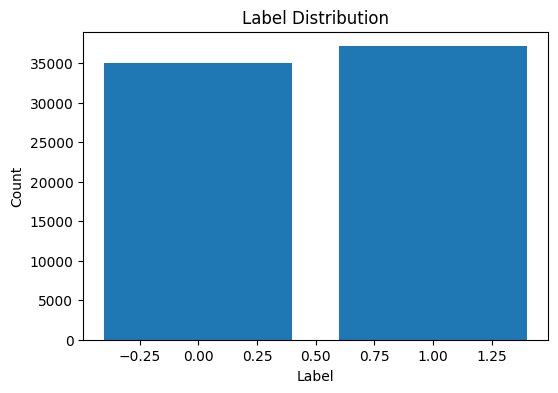

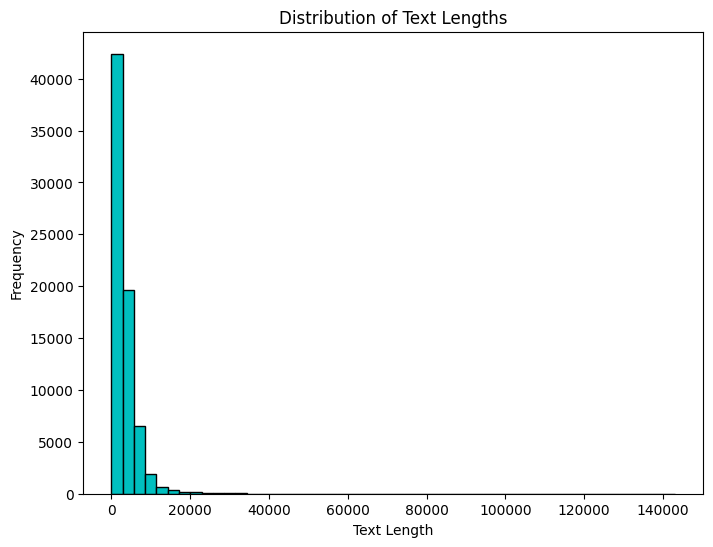

In [ ]:
import matplotlib.pyplot as plt

# 레이블 분포 시각화
label_counts = df_clean['label'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

# 텍스트 길이 분포 시각화
plt.figure(figsize=(8, 6))
plt.hist(text_lengths, bins=50, color='c', edgecolor='black')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

# 토큰 저장

In [ ]:
import torch

# 전체 inputs 객체를 하나의 파일로 저장
torch.save(inputs, 'inputs.pt')

In [ ]:
# 파일에서 inputs 객체 로드
inputs = torch.load('inputs.pt')

# 데이터셋

## 새로 생성

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm

# RoBERTa 토크나이저 및 모델 로드
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta = RobertaModel.from_pretrained('roberta-base')

# 텍스트 데이터 전처리 함수 (배치 처리)
def preprocess_for_roberta(texts, tokenizer, batch_size=32, max_length=128):
    inputs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing"):
        batch_texts = texts[i:i + batch_size]
        batch_inputs = tokenizer(
            batch_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'  # PyTorch tensor 반환
        )
        inputs.append(batch_inputs)
    return inputs

# RoBERTa 모델을 사용하여 입력의 임베딩을 계산하는 함수
def get_embeddings(inputs, model, device):
    """
    입력에 대한 임베딩을 생성합니다.
    """
    with torch.no_grad():
        input_ids = inputs['input_ids'].to(device)  # 텐서를 지정된 장치로 이동
        attention_mask = inputs['attention_mask'].to(device)  # 텐서를 지정된 장치로 이동
        model.to(device)  # 모델을 지정된 장치로 이동
        outputs = model(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch_size, seq_length, d_model)


# 데이터셋 클래스 정의
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels, model, device):
        self.encodings = encodings
        self.labels = labels
        self.model = model
        self.device = device

    def __len__(self):
        return sum(len(batch['input_ids']) for batch in self.encodings)

    def __getitem__(self, idx):
        # 전체 데이터셋 인덱스에서 적절한 배치와 배치 인덱스를 찾기
        batch_index = 0
        while idx >= len(self.encodings[batch_index]['input_ids']):
            idx -= len(self.encodings[batch_index]['input_ids'])
            batch_index += 1

        batch = self.encodings[batch_index]
        inputs = {key: val[idx].unsqueeze(0).to(self.device) for key, val in batch.items()}  # 모든 텐서를 device로 이동
        embeddings = get_embeddings(inputs, self.model, self.device)  # 임베딩을 계산한 후 장치로 이동
        item = {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask'], 'embeddings': embeddings.to(self.device)}
        item['labels'] = torch.tensor(self.labels[idx + sum(len(b['input_ids']) for b in self.encodings[:batch_index])]).to(self.device)
        return item


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 텍스트 데이터 준비
texts = df_clean['combined_text'].tolist()
labels = df_clean['label'].tolist()


In [ ]:
# 배치로 텍스트 데이터 전처리
batch_encodings = preprocess_for_roberta(texts, tokenizer, batch_size=64)



Processing: 100%|██████████| 1128/1128 [04:19<00:00,  4.35it/s]


In [ ]:
# 데이터셋 준비
# 배치 처리를 위해 각 배치의 인코딩을 따로 전달하도록 수정
dataset = FakeNewsDataset(batch_encodings, labels, roberta, device)

# 데이터로더 준비
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 각 배치에 대해 하나의 큰 텐서를 사용하므로 batch_size=1
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
import os

# 임베딩을 저장할 파일 경로
embedding_file = '/content/embeddings.pt'

# 텍스트 데이터 전처리 함수와 임베딩을 동시에 계산하여 저장하는 함수
def preprocess_and_save_embeddings(texts, tokenizer, model, device, batch_size=8, max_length=128, output_file='embeddings.pt'):
    all_embeddings = []
    model.to(device)

    # 텍스트 데이터를 배치 단위로 전처리하고 임베딩을 계산합니다.
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing"):
        batch_texts = texts[i:i + batch_size]
        batch_inputs = tokenizer(
            batch_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'  # PyTorch tensor 반환
        )

        # 입력을 GPU로 전송
        input_ids = batch_inputs['input_ids'].to(device)
        attention_mask = batch_inputs['attention_mask'].to(device)

        # 임베딩 계산
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state.cpu()  # GPU에서 CPU로 이동

        # 배치 임베딩을 리스트에 추가
        all_embeddings.append(embeddings)

    # 모든 임베딩을 하나의 텐서로 결합하여 저장
    all_embeddings = torch.cat(all_embeddings, dim=0)  # (total_samples, seq_length, d_model)
    torch.save(all_embeddings, output_file)
    print(f"All embeddings have been saved in {output_file}")

# 텍스트 데이터 준비
texts = df_clean['combined_text'].tolist()
labels = df_clean['label'].tolist()

# 임베딩 계산 및 저장
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preprocess_and_save_embeddings(texts, tokenizer, roberta, device)

Processing: 100%|██████████| 9017/9017 [07:36<00:00, 19.77it/s]


All embeddings have been saved in embeddings.pt


In [ ]:
import torch

# 임베딩을 저장한 파일 경로
embedding_file = './embeddings.pt'

# 저장된 임베딩을 하나의 파일에서 로드하는 함수
def load_embeddings(embedding_file):
    embeddings = torch.load(embedding_file)
    return embeddings

# 임베딩 로드
loaded_embeddings = load_embeddings(embedding_file)
print(f"Loaded embeddings with shape: {loaded_embeddings.shape}")


FileNotFoundError: [Errno 2] No such file or directory: './embeddings.pt'

## 로드

In [ ]:
# 전처리된 데이터를 하나의 큰 텐서로 병합
encodings = {
    'input_ids': torch.cat([batch['input_ids'] for batch in inputs], dim=0),
    'attention_mask': torch.cat([batch['attention_mask'] for batch in inputs], dim=0)
}

In [ ]:
# 데이터셋 클래스 정의
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        """
        :param encodings: 입력 시퀀스의 토큰화된 결과를 포함하는 사전 (input_ids와 attention_mask를 포함해야 함)
        :param labels: 레이블 리스트
        """
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
# 레이블 리스트 생성
labels = df_clean['label'].tolist()

In [ ]:
# 데이터셋 준비
dataset = FakeNewsDataset(encodings, labels)


In [ ]:
# 데이터로더 준비
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 모델

## 인코더

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(torch.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

## 디코더

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None):
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(torch.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

## Segment IDs 생성

In [ ]:
# 세그먼트 ID 생성 함수
def create_segment_ids(input_ids):
    """
    입력 시퀀스에 대한 세그먼트 ID를 생성하는 함수.
    각 입력에 대해 첫 번째 세그먼트는 0, 두 번째 세그먼트는 1로 설정.
    """
    segment_ids = torch.zeros_like(input_ids)
    sep_idx = (input_ids == tokenizer.sep_token_id).nonzero()
    for i in range(sep_idx.size(0)):
        if sep_idx[i, 1] + 1 < input_ids.size(1):
            segment_ids[i, sep_idx[i, 1] + 1:] = 1
    return segment_ids

## 세그먼트 임베딩

In [ ]:
class SegmentEmbedding(nn.Module):
    def __init__(self, d_model, n_segments=2):
        """
        세그먼트 임베딩 초기화
        :param d_model: 임베딩 차원 크기 (예: 768)
        :param n_segments: 사용할 세그먼트의 개수 (기본값: 2)
        """
        super(SegmentEmbedding, self).__init__()
        self.segment_embedding = nn.Embedding(n_segments, d_model)

    def forward(self, segment_ids):
        """
        세그먼트 임베딩을 반환하는 함수
        :param segment_ids: 각 토큰의 세그먼트 ID가 들어 있는 텐서 (예: [0, 0, 0, 1, 1])
        :return: 세그먼트 임베딩 텐서 (batch_size, seq_length, d_model)
        """
        # 세그먼트 ID에 대해 세그먼트 임베딩을 수행
        segment_emb = self.segment_embedding(segment_ids)  # (batch_size, seq_length, d_model)
        return segment_emb

## 노이즈 추가

In [ ]:
def add_noise_and_mask(inputs, tokenizer, device, mask_prob=0.15, noise_prob=0.1):
    """
    입력 텍스트에 노이즈를 추가하고, 일부 토큰을 마스킹하는 함수.
    :param inputs: 텍스트의 토큰화된 입력 (input_ids)
    :param tokenizer: RoBERTa 토크나이저
    :param device: 사용 중인 디바이스 (cpu 또는 cuda)
    :param mask_prob: 마스킹 확률 (기본값 15%)
    :param noise_prob: 추가 노이즈 확률 (기본값 10%)
    :return: 노이즈가 추가되고 마스킹된 input_ids
    """
    # 모든 텐서를 동일한 디바이스로 이동
    input_ids = inputs['input_ids'].clone().to(device)  # 텐서를 장치로 이동하고, 복사본을 사용하여 수정
    attention_mask = inputs['attention_mask'].clone().to(device)

    # input_ids 텐서를 Long 타입으로 변환
    input_ids = input_ids.long()

    # 마스킹 및 노이즈 추가
    rand_for_mask = torch.rand(input_ids.shape, device=device)
    mask_arr = (rand_for_mask < mask_prob) & (input_ids != tokenizer.cls_token_id) & \
               (input_ids != tokenizer.pad_token_id) & (input_ids != tokenizer.sep_token_id)

    input_ids[mask_arr] = tokenizer.mask_token_id

    # 노이즈 추가
    noise_arr = (rand_for_mask < noise_prob) & ~mask_arr
    for i in range(input_ids.shape[0]):
        random_replace = torch.rand(input_ids[i].shape, device=device) < 0.1
        random_tokens = torch.randint(len(tokenizer), input_ids[i].shape, dtype=torch.long, device=device)
        input_ids[i][noise_arr[i] & random_replace] = random_tokens[noise_arr[i] & random_replace]

    return input_ids


## 모델

In [ ]:
class FNDNSModel(nn.Module):
    def __init__(self, d_model=768, num_heads=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1, num_classes=2):
        super(FNDNSModel, self).__init__()
        self.segment_embedding = nn.Embedding(2, d_model)  # 세그먼트 임베딩의 차원을 d_model과 동일하게 설정
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout) for _ in range(num_encoder_layers)])
        self.decoder_layers = nn.ModuleList([TransformerDecoderLayer(d_model, num_heads, dim_feedforward, dropout) for _ in range(num_decoder_layers)])
        self.fc_out = nn.Linear(d_model, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, src, src_mask, src_segment, tgt, tgt_mask):
        # 세그먼트 임베딩 추가
        segment_emb = self.segment_embedding(src_segment)  # (batch_size, seq_length, d_model)

        # src와 segment_emb의 차원을 맞춰서 더하기
        # src와 segment_emb는 (batch_size, seq_length, d_model)이어야 함
        if segment_emb.dim() == 2:
            segment_emb = segment_emb.unsqueeze(1)  # (batch_size, 1, d_model)

        # src의 크기에 맞추어 확장
        if segment_emb.size(1) != src.size(1):
            segment_emb = segment_emb.expand(-1, src.size(1), -1)  # (batch_size, seq_length, d_model)

        src = src + segment_emb

        # 인코더 처리
        for layer in self.encoder_layers:
            src = layer(src, src_mask)

        # 디코더 처리
        output = tgt
        for layer in self.decoder_layers:
            output = layer(output, src, tgt_mask, src_mask)

        # 최종 출력
        output = self.fc_out(output[:, 0, :])
        return self.softmax(output)

# 학습루프

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            # 각 배치의 데이터와 임베딩을 장치로 이동
            embeddings = batch['embeddings'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Segment IDs 생성
            segment_ids = torch.zeros_like(embeddings[:, :, 0], dtype=torch.long).to(device)  # 모든 세그먼트를 0으로 설정

            # 손상된 입력 생성 (노이즈 추가 및 마스킹)
            noisy_input_ids = add_noise_and_mask({'input_ids': embeddings, 'attention_mask': attention_mask}, tokenizer, device)
            noisy_input_ids = noisy_input_ids.to(device)

            optimizer.zero_grad()

            # 모델 순전파
            outputs = model(noisy_input_ids, attention_mask, segment_ids, noisy_input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1} | Training Loss: {total_loss / len(train_loader)}")
        evaluate_model(model, val_loader, device)


In [ ]:
def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            # 각 배치의 데이터와 임베딩을 장치로 이동
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Segment IDs 생성
            segment_ids = torch.zeros_like(input_ids, dtype=torch.long).to(device)  # 모든 세그먼트를 0으로 설정

            # 모델 예측
            outputs = model(input_ids, attention_mask, segment_ids, input_ids, attention_mask)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")
    model.train()


## 하이퍼파라미터

In [ ]:
# 하이퍼파라미터 설정
d_model = 768
num_heads = 8
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
dropout = 0.1
num_classes = 2

In [ ]:
# 학습 준비
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FNDNSModel(
    d_model=d_model,
    num_heads=num_heads,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    num_classes=num_classes
).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

In [ ]:
# 모델 학습
train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=3)

Training Epoch 1:   0%|          | 0/57707 [00:00<?, ?it/s]


RuntimeError: expand(torch.cuda.FloatTensor{[1, 1, 768, 768]}, size=[1, 1, 128]): the number of sizes provided (3) must be greater or equal to the number of dimensions in the tensor (4)

# SBERT

# 1. 데이터 전처리

In [ ]:
print(df.head())

                                               title  \
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1                                                NaN   
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3  Bobby Jindal, raised Hindu, uses story of Chri...   
4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB
None


In [ ]:
print(df['title'].isnull().sum())
print(df['text'].isnull().sum())
print(df['label'].isnull().sum())

558
39
0


In [ ]:
data=df.dropna(axis=0)

In [ ]:
print(data['title'].isnull().sum())
print(data['text'].isnull().sum())
print(data['label'].isnull().sum())

0
0
0


In [ ]:
# 텍스트와 타이틀 결합
data['text'] = data['title'] + " " + data['text']
data = data[['text', 'label']]

<ipython-input-8-e734cf04222f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['title'] + " " + data['text']


In [ ]:
data

text  label
0      LAW ENFORCEMENT ON HIGH ALERT Following Threat...      1
2      UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...      1
3      Bobby Jindal, raised Hindu, uses story of Chri...      0
4      SATAN 2: Russia unvelis an image of its terrif...      1
5      About Time! Christian Group Sues Amazon and SP...      1
...                                                  ...    ...
72129  Russians steal research on Trump in hack of U....      0
72130   WATCH: Giuliani Demands That Democrats Apolog...      1
72131  Migrants Refuse To Leave Train At Refugee Camp...      0
72132  Trump tussle gives unpopular Mexican leader mu...      0
72133  Goldman Sachs Endorses Hillary Clinton For Pre...      1

[71537 rows x 2 columns]

In [ ]:
# 레이블 카운트
label_counts = df['label'].value_counts()
print(label_counts)

# 클래스별 비율 확인
label_ratios = df['label'].value_counts(normalize=True)
print(label_ratios)

label
1    37106
0    35028
Name: count, dtype: int64
label
1    0.514404
0    0.485596
Name: proportion, dtype: float64


# 토큰 임베딩

In [ ]:
!pip install sentence-transformers

In [ ]:
import torch
from transformers import BartTokenizer, BartModel
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd

# 최적화 설정
torch.backends.cudnn.benchmark = True  # GPU 최적화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터셋 정의
class NewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx, 0]
        encoding = self.tokenizer(text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}  # 배치 차원 제거
        return encoding

# 데이터 로드 및 전처리
model = SentenceTransformer('all-MiniLM-L6-v2')

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from tqdm import tqdm

# 배치 사이즈 설정
batch_size = 128
total_batches = len(data) // batch_size + 1

# 벡터 초기화
all_vectors = []

# 벡터화 수행 및 진행 상황 출력
for i in tqdm(range(0, len(data), batch_size), desc="Processing batches"):
    batch_texts = data['text'][i:i+batch_size].tolist()
    embeddings = model.encode(batch_texts, batch_size=batch_size, convert_to_tensor=True, device=device)
    all_vectors.extend(embeddings.cpu().numpy())

    # print(f"Processed batch {i//batch_size + 1}/{total_batches}")

Processing batches: 100%|██████████| 559/559 [01:27<00:00,  6.36it/s]


In [ ]:
len(all_vectors)

71537

In [ ]:
# 벡터를 DataFrame으로 변환
vector_df = pd.DataFrame(all_vectors)
vector_df['label'] = data['label'].values

In [ ]:
vector_df

0         1         2         3         4         5         6  \
0     -0.008818 -0.001956 -0.022637  0.030399  0.096721  0.024922  0.062340   
1      0.068621  0.043289 -0.059886  0.029838  0.058201  0.012054  0.046609   
2     -0.008437  0.067539 -0.085811 -0.008455  0.057599  0.005268  0.017612   
3      0.036160  0.035061 -0.062981 -0.000053  0.018366 -0.010113 -0.041939   
4     -0.055806  0.045611 -0.076916  0.005441  0.057404  0.030541  0.010850   
...         ...       ...       ...       ...       ...       ...       ...   
71532 -0.046689 -0.043160  0.005569 -0.026756  0.061967 -0.022007  0.083302   
71533 -0.037746  0.082985  0.004951  0.018544  0.005917 -0.016058  0.012583   
71534 -0.010403  0.031983 -0.035177  0.065481  0.093416  0.032548 -0.013071   
71535 -0.012462  0.035592  0.023589  0.000602  0.069685 -0.048896  0.074785   
71536  0.015964 -0.095582  0.032870  0.025266  0.042872  0.014829  0.007320   

              7         8         9  ...       375       376       377  \
0      0.002199 -0.009299 -0.026329  ... -0.091296  0.015135 -0.046467   
1     -0.056433 -0.018829  0.089386  ... -0.056936  0.013663  0.021834   
2     -0.037805  0.093543 -0.018007  ... -0.029729  0.006173  0.031705   
3      0.068333 -0.022210 -0.018656  ...  0.067490 -0.011613 -0.096311   
4     -0.089523  0.103785  0.009073  ... -0.028265  0.011932  0.032236   
...         ...       ...       ...  ...       ...       ...       ...   
71532 -0.046447  0.080071  0.016410  ...  0.023045  0.034673 -0.040586   
71533 -0.065918 -0.022187 -0.051978  ... -0.015544  0.003241 -0.015267   
71534  0.062305 -0.033010 -0.063703  ... -0.046014 -0.066694  0.005924   
71535  0.062296  0.024902 -0.074493  ... -0.017525 -0.021166 -0.000190   
71536  0.032726 -0.009684 -0.082291  ... -0.036256 -0.092729 -0.005908   

            378       379       380       381       382       383  label  
0     -0.046307  0.015935  0.026134 -0.030865 -0.047281  0.012353      1  
1      0.013222  0.029766  0.011869 -0.031871 -0.034029  0.031087      1  
2      0.002552 -0.077032  0.027433 -0.085631 -0.052072 -0.045564      0  
3     -0.039798 -0.012028  0.017144 -0.146528 -0.050490  0.049469      1  
4     -0.032224 -0.003333  0.013883 -0.121875 -0.006950  0.012722      1  
...         ...       ...       ...       ...       ...       ...    ...  
71532 -0.018765 -0.025881 -0.042462 -0.011427  0.012590 -0.041516      0  
71533  0.016063  0.066616 -0.009672 -0.027563 -0.017914 -0.025669      1  
71534 -0.013901  0.011132 -0.045269  0.040030 -0.044759  0.035846      0  
71535  0.003494 -0.020333  0.019231 -0.055103 -0.024711  0.062653      0  
71536 -0.043464 -0.010333 -0.030391 -0.080501  0.069729 -0.018404      1  

[71537 rows x 385 columns]

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

# position embedding 함수
def add_positional_embeddings(embeddings, max_len=384, device="cuda"):
    batch_size, embed_dim = embeddings.size(0), embeddings.size(1)

    position_ids = torch.arange(0, max_len, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embed_dim, 2, device=device) * -(np.log(10000.0) / embed_dim))
    position_embeddings = torch.zeros((max_len, embed_dim), device=device)
    position_embeddings[:, 0::2] = torch.sin(position_ids * div_term)
    position_embeddings[:, 1::2] = torch.cos(position_ids * div_term)

    position_embeddings = position_embeddings[:embeddings.size(0), :]
    return embeddings + position_embeddings

# segment embedding 함수
def add_segment_embeddings(embeddings, device="cuda"):
    batch_size, embed_dim = embeddings.size(0), embeddings.size(1)
    segment_embeddings = torch.zeros((batch_size, embed_dim), device=device)

    return embeddings + segment_embeddings

# 최종 임베딩 처리
def process_embeddings(embeddings, max_len=384, device="cuda"):
    embeddings = torch.tensor(np.array(embeddings), device=device)

    # 위치 임베딩 추가
    embeddings = add_positional_embeddings(embeddings, max_len=max_len, device=device)

    # 세그먼트 임베딩 추가
    embeddings = add_segment_embeddings(embeddings, device=device)

    return embeddings.cpu().numpy()

# 벡터화된 데이터프레임에 임베딩 추가
def process_all_embeddings(all_vectors, batch_size=128):
    final_embeddings = []
    num_batches = len(all_vectors) // batch_size + 1

    for i in tqdm(range(0, len(all_vectors), batch_size), desc="Processing batches"):
        batch_vectors = all_vectors[i:i + batch_size]
        batch_embeddings = process_embeddings(batch_vectors)
        final_embeddings.extend(batch_embeddings)

    return np.array(final_embeddings)

In [ ]:
# 벡터화된 데이터프레임에 임베딩 추가
final_embeddings = process_all_embeddings(all_vectors)

Processing batches: 100%|██████████| 559/559 [00:00<00:00, 1221.58it/s]


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 데이터를 PyTorch Tensor로 변환 및 결합
final_embeddings_tensor = torch.tensor(final_embeddings, dtype=torch.float32)
labels_tensor = torch.tensor(vector_df['label'].values, dtype=torch.long)

# TensorDataset을 이용하여 결합
dataset = TensorDataset(final_embeddings_tensor, labels_tensor)

# DataLoader 생성
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
dataset

# 데이터 저장

In [ ]:
import numpy as np

# 벡터화된 데이터와 레이블을 함께 저장하기 위해 결합
final_embeddings_with_labels = np.hstack((final_embeddings, vector_df['label'].values.reshape(-1, 1)))

# 벡터화된 데이터를 NumPy 배열로 저장
np.save('final_embeddings.npy', final_embeddings)

# 레이블도 함께 저장
np.save('labels.npy', vector_df['label'].values)

# 또는 .csv 형식으로 저장
np.savetxt('final_embeddings_with_labels.csv', final_embeddings_with_labels, delimiter=',')

In [ ]:
# 벡터화된 데이터를 DataFrame으로 변환
final_embeddings_df = pd.DataFrame(final_embeddings)
final_embeddings_df['label'] = vector_df['label'].values

# 엑셀 파일로 저장
final_embeddings_df.to_excel('final_embeddings.xlsx', index=False)

# 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
import torch

from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# 저장된 데이터를 불러오기
final_embeddings = np.load('final_embeddings.npy', allow_pickle=True)
labels = np.load('labels.npy')

# PyTorch TensorDataset으로 변환
final_embeddings_tensor = torch.tensor(final_embeddings, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# TensorDataset을 이용하여 결합
dataset = TensorDataset(final_embeddings_tensor, labels_tensor)

# DataLoader 생성
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# 엑셀 파일에서 데이터 불러오기
loaded_df = pd.read_excel('final_embeddings.xlsx')

# 데이터와 레이블 분리
final_embeddings = loaded_df.drop('label', axis=1).values
labels = loaded_df['label'].values

# PyTorch Tensor로 변환
final_embeddings_tensor = torch.tensor(final_embeddings, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# TensorDataset을 이용하여 결합
dataset = TensorDataset(final_embeddings_tensor, labels_tensor)

# DataLoader 생성
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


# 또는 .csv 파일 불러오기
loaded_embeddings  = np.loadtxt('final_embeddings_with_labels.csv', delimiter=',')

# 임베딩과 레이블 분리
final_embeddings = loaded_embeddings[:, :-1]  # 임베딩
labels = loaded_embeddings[:, -1].astype(int)  # 레이블

# PyTorch Tensor로 변환
final_embeddings_tensor = torch.tensor(final_embeddings, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# TensorDataset을 이용하여 결합
dataset = TensorDataset(final_embeddings_tensor, labels_tensor)

# DataLoader 생성
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 트랜스포머 모델

## 모델 구조

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

### position encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=700):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]


### attetion masking

In [ ]:
# 패딩 마스크 생성
def create_padding_mask(seq):
    # 시퀀스의 패딩 위치를 찾고 마스크 생성 (패딩은 0으로 표시)
    seq = seq.eq(0)
    return seq.unsqueeze(1).unsqueeze(2)  # 배치 차원과 헤드 차원을 추가하여 마스크 모양을 맞춤

# Look-ahead 마스크 생성
def create_look_ahead_mask(size):
    # Look-ahead 마스크를 생성하여 미래의 토큰을 가리는 삼각형 형태의 마스크를 만듦
    mask = torch.tril(torch.ones(size, size)).to(torch.bool)
    return mask

### token masking

In [ ]:
# 마스킹 레이어 추가
def mask_tokens(inputs, tokenizer, mask_prob=0.15):
    """
    입력 시퀀스의 일부 토큰을 마스킹하는 함수.
    - inputs: 토큰화된 입력 시퀀스
    - tokenizer: 사용 중인 토크나이저
    - mask_prob: 마스킹 확률
    """
    labels = inputs.clone()
    # 확률에 따라 마스크할 위치 결정
    masked_indices = torch.bernoulli(torch.full(labels.shape, mask_prob)).bool()
    labels[~masked_indices] = -100  # 마스크되지 않은 토큰은 손실 계산에서 제외

    # 80%는 [MASK] 토큰으로 대체
    inputs[masked_indices] = tokenizer.mask_token_id

    # 나머지 20%는 10%는 무작위 토큰, 10%는 원래 토큰 유지
    return inputs, labels

In [ ]:
def mask_vectors(inputs, seq_length=512, mask_prob=0.15):
    """
    Function to mask vectors for input data. It ensures that the output tensor shapes are consistent.
    - inputs: Tensor of shape [batch_size, seq_length, input_dim]
    - seq_length: Expected sequence length for the model
    - mask_prob: Probability of masking each input vector
    """
    # Ensure inputs has three dimensions: [batch_size, seq_length, input_dim]
    if len(inputs.shape) == 2:
        inputs = inputs.unsqueeze(1)  # Shape becomes [batch_size, 1, input_dim]

    batch_size, _, input_dim = inputs.shape

    # Adjust inputs to the expected sequence length of the model
    if inputs.shape[1] != seq_length:
        padded_inputs = torch.zeros((batch_size, seq_length, input_dim), device=inputs.device)
        padded_inputs[:, :inputs.shape[1], :] = inputs
        inputs = padded_inputs

    # Masking operation: create a mask tensor of the same shape as the sequence length
    masked_indices = torch.bernoulli(torch.full((batch_size, seq_length), mask_prob)).bool()

    # Expand mask to match input dimensions [batch_size, seq_length, input_dim]
    masked_indices = masked_indices.unsqueeze(-1).expand(batch_size, seq_length, input_dim)

    # Create a mask tensor with the same shape as inputs
    mask_tensor = torch.zeros_like(inputs)  # Shape: [batch_size, seq_length, input_dim]

    # Create a mask for labels that matches the model's output dimension [batch_size, seq_length]
    labels = inputs.clone()
    labels[~masked_indices] = -100  # Masked elements are set to -100 in labels

    # Apply masking: replace masked elements with zeros
    inputs[masked_indices] = mask_tensor[masked_indices]

    # Reduce masked_labels to match the output dimension for classification
    labels = labels.mean(dim=-1)  # Reduce the last dimension to match output [batch_size, seq_length]

    return inputs, labels


### self attetion

In [ ]:
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super(SelfAttention, self).__init__()
        # Query, Key, Value를 계산하기 위한 선형 변환 레이어
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        # 스케일링 팩터를 설정하여 점곱 계산 시 안정성을 높임
        self.scale = 1 / (d_model ** 0.5)

    def forward(self, x):
        # Query, Key, Value 계산
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        # Query와 Key의 점곱 계산 후 스케일링 적용
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        # Softmax를 사용하여 Attention Weight 계산
        attn = torch.nn.functional.softmax(scores, dim=-1)
        # Attention Weight를 사용하여 Value의 가중합을 계산
        context = torch.matmul(attn, V)
        # Residual Connection 적용 후 반환
        return context + x

### Scaled Dot-Product Attention

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k  # 스케일링을 위한 차원 크기

    def forward(self, Q, K, V, mask=None):
        # Query와 Key의 점곱을 스케일링하여 Attention Score 계산
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        if mask is not None:
            # 마스크 적용 (마스크된 부분에 -inf를 할당)
            scores = scores.masked_fill(mask == 0, -1e9)
        # Softmax를 적용하여 Attention Weight 계산
        attn = torch.nn.functional.softmax(scores, dim=-1)
        # Attention Weight를 사용하여 최종 Value 계산
        return torch.matmul(attn, V), attn

### Multi-Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads  # 어텐션 헤드 수
        self.d_k = d_model // num_heads  # 각 헤드의 차원 크기
        self.d_model = d_model

        # Query, Key, Value 계산을 위한 선형 변환 레이어
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        # 최종 출력 계산을 위한 선형 변환 레이어
        self.fc = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)

        # 선형 변환 후 헤드 수에 따라 분리
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # 스케일드 점곱 어텐션 적용
        out, attn = ScaledDotProductAttention(self.d_k)(Q, K, V, mask)

        # 여러 헤드를 결합하고 최종 선형 변환을 적용
        out = out.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.fc(out)

        return out

### Position-wise Feed Forward Network

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # 두 개의 선형 레이어로 구성된 피드 포워드 네트워크
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        # 드롭아웃 레이어
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 활성화 함수와 드롭아웃을 적용하여 두 번째 선형 레이어를 통과
        return self.fc2(self.dropout(torch.nn.functional.relu(self.fc1(x))))

### Encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward, dropout, activation_function=nn.GELU()):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            activation_function,
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        # Ensure self-attention and feed-forward layers preserve sequence length
        attn_output = self.self_attn(x, x, x, src_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        return x

### Decoder

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward, dropout, activation_function=nn.GELU()):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            activation_function,
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, tgt_mask=None, memory_mask=None):
        # Ensure self-attention and cross-attention layers preserve sequence length
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        cross_attn_output = self.cross_attn(x, memory, memory, memory_mask)
        x = self.norm2(x + self.dropout(cross_attn_output))
        ffn_output = self.ffn(x)
        x = self.norm3(x + self.dropout(ffn_output))
        return x

### FND-NS 모델 결합

In [ ]:
class FNDNSModel(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, num_labels, seq_length, activation_function=nn.GELU()):
        super(FNDNSModel, self).__init__()
        self.d_model = d_model
        self.seq_length = seq_length

        # Projection layer to project input dimension to model dimension
        self.input_projection = nn.Linear(input_dim, d_model)

        # Positional encoding for the sequence
        self.positional_encoding = nn.Embedding(seq_length, d_model)

        # Encoder layers with sequence length preserved
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, dim_feedforward, dropout, activation_function)
            for _ in range(num_encoder_layers)
        ])

        # Decoder layers with sequence length preserved
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, dim_feedforward, dropout, activation_function)
            for _ in range(num_decoder_layers)
        ])

        # Output layer to project to the number of labels
        self.fc_out = nn.Linear(d_model, num_labels)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # Project input to model dimension
        src = self.input_projection(src)  # Shape: (batch_size, seq_length, d_model)
        tgt = self.input_projection(tgt)  # Shape: (batch_size, seq_length, d_model)

        # Apply positional encoding to src and tgt
        src = src + self.positional_encoding(torch.arange(self.seq_length, device=src.device))
        tgt = tgt + self.positional_encoding(torch.arange(self.seq_length, device=tgt.device))

        # Pass through encoder layers
        for layer in self.encoder_layers:
            src = layer(src, src_mask)

        # Memory from encoder
        memory = src

        # Pass through decoder layers
        for layer in self.decoder_layers:
            tgt = layer(tgt, memory, tgt_mask)

        # Output layer to generate final predictions
        output = self.fc_out(tgt)  # Output shape should be (batch_size, seq_length, num_labels)
        return output

## 학습

In [ ]:
# 하이퍼파라미터 설정
input_dim = 384  # 입력 데이터 크기 (임베딩된 벡터의 차원)
d_model = 512  # 모델의 임베딩 차원
num_heads = 8  # 어텐션 헤드 수
num_encoder_layers = 12  # 인코더 레이어 수
num_decoder_layers = 12  # 디코더 레이어 수
dim_feedforward = 1024  # FFN 차원
dropout = 0.1  # 드롭아웃 확률
num_labels = 2  # 클래스 수
batch_size = 16  # 배치 크기
learning_rate = 1e-3  # 학습률
epochs = 10  # 에포크 수
seq_length = 512  # 시퀀스 길이
warmup_steps = 500  # 워밍업 스텝 수
activation_function = nn.GELU()  # 활성화 함수

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# 데이터를 PyTorch Tensor로 변환 및 결합
#final_embeddings_tensor = torch.tensor(final_embeddings, dtype=torch.float32)
#labels_tensor = torch.tensor(vector_df['label'].values, dtype=torch.long)

# TensorDataset을 이용하여 결합
# dataset = TensorDataset(final_embeddings_tensor, labels_tensor)

import torch
from torch.utils.data import TensorDataset, random_split

# 데이터셋의 전체 크기
n_total = len(final_embeddings_tensor)

# 나눌 비율에 맞는 크기 계산
n_test = int(0.15 * n_total)
n_val = int(0.10 * n_total)
n_train = n_total - n_test - n_val

# 데이터를 무작위로 섞음
indices = torch.randperm(n_total)

# 무작위로 섞인 데이터를 비율에 따라 나누기
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

train_embeddings = final_embeddings_tensor[train_indices]
val_embeddings = final_embeddings_tensor[val_indices]
test_embeddings = final_embeddings_tensor[test_indices]

train_labels = labels_tensor[train_indices]
val_labels = labels_tensor[val_indices]
test_labels = labels_tensor[test_indices]

# TensorDataset을 이용하여 결합
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)
test_dataset = TensorDataset(test_embeddings, test_labels)



NameError: name 'TensorDataset' is not defined

In [ ]:
import torch

# Convert TensorFlow tensors to PyTorch tensors
train_features_tensor = torch.tensor(train_features.numpy(), dtype=torch.float32)
val_features_tensor = torch.tensor(val_features.numpy(), dtype=torch.float32)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming train_labels and val_labels are already in PyTorch tensor format
train_dataset = TensorDataset(train_features_tensor, train_labels)
val_dataset = TensorDataset(val_features_tensor, val_labels)

AttributeError: 'list' object has no attribute 'size'

In [ ]:
# DataLoader 생성
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,  # 코랩에서는 2~4로 설정
    pin_memory=True,
    drop_last=True,
    prefetch_factor=4  # Adjust based on available memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=8,  # 코랩에서는 2~4로 설정
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=8,  # 코랩에서는 2~4로 설정
    pin_memory=True
)

NameError: name 'train_dataset' is not defined

In [ ]:
from transformers import get_linear_schedule_with_warmup
# import torch_xla.core.xla_model as xm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

# 모델 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = xm.xla_device()
model = FNDNSModel(input_dim, d_model, num_heads, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, num_labels, seq_length, activation_function).to(device)

# 옵티마이저 및 손실 함수 정의
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# 스케줄러 설정
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

In [ ]:
# cuda delete cache
torch.cuda.empty_cache()

In [ ]:
import gc

gc.collect()

2622

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)  # Set default logging level to INFO

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        # Ensure inputs have the correct shape [batch_size, seq_length, input_dim]
        if len(inputs.shape) == 2:
            inputs = inputs.unsqueeze(1)  # Adding sequence dimension if missing

        optimizer.zero_grad()

        # Apply vector masking correctly to match input shape
        inputs, masked_labels = mask_vectors(inputs, seq_length=512)

        # Debugging prints are now replaced with logging
        logging.debug(f"Initial inputs shape: {inputs.shape}")
        logging.debug(f"Masked inputs shape: {inputs.shape}")
        logging.debug(f"Masked labels shape before flattening: {masked_labels.shape}")

        # Ensure the masking output shape matches expected model input shape
        inputs = inputs.view(inputs.size(0), -1, inputs.size(-1))  # [batch_size, seq_length, input_dim]
        masked_labels = masked_labels.view(inputs.size(0), -1)  # [batch_size, seq_length]

        # Assert that the shapes are as expected
        assert inputs.shape[1] == masked_labels.shape[1], f"Mismatch in sequence length after masking: {inputs.shape} vs {masked_labels.shape}"

        # Pass through the model
        outputs = model(inputs, inputs)

        logging.debug(f"Outputs shape before flattening: {outputs.shape}")

        # Flatten masked_labels and outputs for valid indices comparison
        masked_labels = masked_labels.view(-1)  # Flattened shape: (batch_size * seq_length)
        outputs = outputs.view(-1, num_labels)  # Flattened shape: (batch_size * seq_length, num_labels)

        # Assert that the flattened shapes are as expected
        assert masked_labels.shape[0] == outputs.shape[0], f"Mismatch in flattened shapes: {masked_labels.shape} vs {outputs.shape}"

        logging.debug(f"masked_labels shape: {masked_labels.shape}")
        logging.debug(f"outputs shape: {outputs.shape}")

        # Ensure correct mask shape
        valid_indices = masked_labels != -100  # This creates a mask of the same shape as the flattened labels

        try:
            valid_outputs = outputs[valid_indices]
            valid_labels = masked_labels[valid_indices]
            valid_labels = valid_labels.long()
        except IndexError as e:
            logging.error(f"IndexError: {e} - Check if the shapes of outputs and valid_indices are aligned.")
            logging.error(f"Outputs shape: {outputs.shape}, valid_indices shape: {valid_indices.shape}")
            raise  # Re-raise the exception after logging

        logging.debug(f"valid_outputs shape: {valid_outputs.shape}")
        logging.debug(f"valid_labels shape: {valid_labels.shape}")

        # Compute loss and backpropagate
        loss = criterion(valid_outputs, valid_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(valid_outputs, 1)
        correct_predictions += (predicted == valid_labels).sum().item()
        total_predictions += valid_labels.size(0)

    epoch_accuracy = correct_predictions / total_predictions
    logging.info(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}')


Epoch 1/10:   6%|▌         | 409/6706 [01:54<29:18,  3.58it/s]


KeyboardInterrupt: 

In [ ]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()  # For scaling the loss when using mixed precision

import torch.autograd.profiler as profiler
import logging

logging.basicConfig(level=logging.INFO)  # Set default logging level to INFO

for epoch in range(epochs):
    model.train()
    with profiler.profile(use_cuda=True) as prof:
        for inputs, labels in train_loader:
            # Your training loop
            pass
    prof.export_chrome_trace(f"trace_{epoch}.json")  # Export for analysis in Chrome
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", disable=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():  # Enable mixed precision
            inputs, masked_labels = mask_vectors(inputs, seq_length=512)
            inputs = inputs.view(inputs.size(0), -1, inputs.size(-1))
            masked_labels = masked_labels.view(inputs.size(0), -1)
            outputs = model(inputs, inputs)
            masked_labels = masked_labels.view(-1)
            outputs = outputs.view(-1, num_labels)
            valid_indices = masked_labels != -100
            valid_outputs = outputs[valid_indices]
            valid_labels = masked_labels[valid_indices].long()

            loss = criterion(valid_outputs, valid_labels)

        scaler.scale(loss).backward()  # Scale loss for stability in mixed precision
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(valid_outputs, 1)
        correct_predictions += (predicted == valid_labels).sum().item()
        total_predictions += valid_labels.size(0)

    epoch_accuracy = correct_predictions / total_predictions
    logging.info(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}')


Epoch 1/10:   2%|▏         | 73/3353 [00:41<30:52,  1.77it/s]


KeyboardInterrupt: 

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


3. Mixed Precision Training
GPU 메모리를 절약하기 위해 혼합 정밀도 학습(Mixed Precision Training)을 사용하는 방법도 있습니다. 이를 위해 PyTorch의 torch.cuda.amp를 사용할 수 있습니다.

In [ ]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# GradScaler 추가
scaler = GradScaler()

# 학습, 검증, 테스트 루프
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # 학습 루프
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs, inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}')

    # 검증 루프
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs, inputs)
                loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)

    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    print(f'Validation Epoch {epoch + 1}/{epochs}, Loss: {val_running_loss/len(val_loader):.4f}, Accuracy: {val_epoch_accuracy:.4f}')



Epoch 1/10: 100%|██████████| 3354/3354 [07:35<00:00,  7.36it/s]


Epoch 1/10, Loss: 0.6978, Accuracy: 0.5017


Validation Epoch 1/10: 100%|██████████| 448/448 [00:17<00:00, 25.43it/s]


Validation Epoch 1/10, Loss: 0.6933, Accuracy: 0.4865


Epoch 2/10:  79%|███████▊  | 2640/3354 [05:58<01:36,  7.36it/s]


KeyboardInterrupt: 

In [ ]:
# 테스트 루프
model.eval()
test_running_loss = 0.0
test_correct_predictions = 0
test_total_predictions = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        with autocast():
            outputs = model(inputs, inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct_predictions += (predicted == labels).sum().item()
        test_total_predictions += labels.size(0)

test_accuracy = test_correct_predictions / test_total_predictions
print(f'Test Loss: {test_running_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}')

4. Gradient Accumulation
배치 크기를 줄이는 대신, 작은 배치로 여러 번의 기울기(gradient)를 계산한 후에 한 번의 역전파를 수행하는 방법입니다.

In [ ]:
accumulation_steps = 4  # 실제 배치 크기 = batch_size * accumulation_steps

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    optimizer.zero_grad()
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}")):
        inputs, labels = inputs.to(device), labels.to(device)

        with autocast():
            outputs = model(inputs, inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}')


Epoch 1/10: 100%|██████████| 2236/2236 [04:35<00:00,  8.11it/s]


Epoch 1/10, Loss: 0.6932, Accuracy: 0.5055


Epoch 2/10: 100%|██████████| 2236/2236 [04:37<00:00,  8.07it/s]


Epoch 2/10, Loss: 0.6931, Accuracy: 0.5069


Epoch 3/10: 100%|██████████| 2236/2236 [04:37<00:00,  8.06it/s]


Epoch 3/10, Loss: 0.6932, Accuracy: 0.5078


Epoch 4/10:  31%|███       | 698/2236 [01:27<03:13,  7.95it/s]


KeyboardInterrupt: 

In [ ]:
accumulation_steps = 2  # 기울기 누적 단계 수

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs, inputs)
        loss = criterion(outputs, labels)
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


## tpu

In [ ]:
# TPU를 사용하려면 런타임 설정에서 TPU를 선택하세요.
# 코드에서 아래와 같이 TPU 장치를 설정할 수 있습니다.
import torch_xla
import torch_xla.core.xla_model as xm
device = xm.xla_device()

print(f'Using device: {device}')


Using device: xla:0


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,  # TPU 환경에서 안정적으로 작동할 수 있도록 설정
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,  # TPU 환경에서 안정적으로 작동할 수 있도록 설정
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,  # TPU 환경에서 안정적으로 작동할 수 있도록 설정
    pin_memory=False
)

In [ ]:
# TPU 디버깅 로그 활성화
import torch_xla.debug.metrics as met


# 학습 루프 수정
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs, inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        xm.optimizer_step(optimizer, barrier=True)  # TPU에서 barrier 옵션 추가

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # 학습 코드 내에서 로그 출력
        # print(met.metrics_report())


    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.4f}')


Epoch 1/10:  11%|█▏        | 190/1677 [03:24<17:55,  1.38it/s]

# 학습 평가

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# 평가 함수 정의
def evaluate_model(model, data_loader):
    model.eval()  # 평가 모드로 전환
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # 성능 지표 계산
    precision = precision_score(all_labels, all_predictions, average='binary')
    recall = recall_score(all_labels, all_predictions, average='binary')
    f1 = f1_score(all_labels, all_predictions, average='binary')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # 성능 지표 출력
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'Confusion Matrix:\n{conf_matrix}')

# 학습 후 평가 함수 호출
evaluate_model(model, test_loader)